In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /My Drive/ANN2425/

Mounted at /content/drive
[Errno 2] No such file or directory: '/My Drive/ANN2425/'
/content


In [8]:
!ls

ConvNeXtSmall_V8_biturbo  data		   processed_dataMaxMax
Convolutional_V8Test1	  EfficientNet_V1  Untitled0.ipynb


In [9]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
import json
import random
# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)


import tensorflow as tf
#from tensorflow import keras as tfk
import keras as tfk       #notice how I'm importing keras and not tensorflow.keras
from keras.layers import Input, Dense, Dropout, Lambda
#from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl


print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")
# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0
2.17.1


In [10]:
def load_processed_data(folder_path="processed_dataMaxMax/finalData"):
    """
    Loads processed training and validation datasets from a specified folder.

    Parameters:
        folder_path (str): Folder path from which to load the data.

    Returns:
        X_train, y_train, X_val, y_val (numpy arrays): Loaded datasets.
    """
    # Load the datasets
    X_train = np.load(os.path.join(folder_path, "X_train.npy"))
    y_train = np.load(os.path.join(folder_path, "y_train.npy"))
    X_val = np.load(os.path.join(folder_path, "X_val.npy"))
    y_val = np.load(os.path.join(folder_path, "y_val.npy"))

    print(f"Processed data loaded from folder: {folder_path}")
    return X_train, y_train, X_val, y_val


In [11]:
X_train, y_train, X_val, y_val = load_processed_data()

indices = np.arange(X_train.shape[0])  # Create an array of indices
np.random.shuffle(indices)  # Shuffle the indices

# Apply the shuffled indices to both X_train and y_train
X_train = X_train[indices]
y_train = y_train[indices]

print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)


Processed data loaded from folder: processed_dataMaxMax/finalData
Training Data Shape: (52916, 96, 96, 3)
Training Label Shape: (52916,)
Validation Data Shape: (1196, 96, 96, 3)
Validation Label Shape: (1196, 1)


In [12]:
def save_model(code, model, history, folder_name):

    """

    Salva il modello e i parametri in una cartella specificata.



    Args:

    - model: il modello da salvare

    - params: dizionario contenente i parametri da salvare (es. learning rate, batch size, etc.)

    - folder_name: nome della cartella di destinazione (default: 'model_folder')

    """

    # Crea la cartella se non esiste

    os.makedirs(folder_name, exist_ok=True)



    if code == 0:

          model_save_path = os.path.join(folder_name, 'weightsTL.keras')

          model.save(model_save_path)

          print(f"ModelTL saved at: {model_save_path}")

    else:

         model_save_path = os.path.join(folder_name, 'weights.keras')

         model.save(model_save_path)

         print(f"Model saved at: {model_save_path}")



    # Salvataggio della history in un file JSON

    if code == 0:

       history_save_path = os.path.join(folder_name, 'historyTL.json')

       with open(history_save_path, 'w') as f:

           json.dump(history, f, indent=4)

       print(f"HistoryTL saved at: {history_save_path}")

    else:

      history_save_path = os.path.join(folder_name, 'history.json')

      with open(history_save_path, 'w') as f:

           json.dump(history, f, indent=4)

      print(f"History saved at: {history_save_path}")

In [13]:
# Define a mapping of labels to their corresponding cell type names
labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}
# Save unique labels
unique_labels = list(labels.values())

In [14]:
from sklearn.utils import class_weight

# Calcola i pesi delle classi
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train.flatten()), y=y_train.flatten())
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.1264475476839237, 1: 0.8432559918408975, 2: 1.1264475476839237, 3: 0.9085851648351648, 4: 1.1264475476839237, 5: 1.1264475476839237, 6: 0.7885670004768717, 7: 1.1180696416497633}


In [15]:
# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(unique_labels))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(unique_labels))



# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (52916, 96, 96, 3), y_train shape: (52916, 8)
X_val shape: (1196, 96, 96, 3), y_val shape: (1196, 8)


In [16]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[-1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [17]:
# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 1e-4


l2_lambda = 1e-4

# Augmentation: set an augmentation layer or not
augmentation = True

# Patience
patience = 10

folder_name = "EfficientNet_V1"

# Dropout

#Name
name = 'EfficientNet_V1'

#Display the architecture
display = False

# Print the defined parameters
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)
print("Augmentation:", augmentation)
print("Patience:", patience)

Batch Size: 128
Learning Rate: 0.0001
Augmentation: True
Patience: 10


In [18]:

# Base model with stochastic depth
initializer = tfk.initializers.GlorotNormal(seed=seed)
regulariser = tfk.regularizers.l2(l2_lambda)

tl_model = tfk.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg",
)
tl_model.trainable = False

# Input preprocessing
inputs = tfkl.Input(shape=(None, None, 3))  # Handle arbitrary input sizes



x = tfkl.Resizing(96, 96)(inputs)


# Feature extraction
x = tl_model(x)

# Stronger regularization in head
x = tfkl.Dense(512,kernel_initializer= initializer)(x)
x = tfkl.Activation('relu')(x)
x = tfkl.Dropout(0.5)(x)

x = tfkl.Dense(256,kernel_initializer= initializer)(x)
x = tfkl.Activation('relu')(x)
x = tfkl.Dropout(0.5)(x)

# Output with label smoothing
outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer= initializer,
    kernel_regularizer=regulariser
)(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

# Cosine decay with warmup
# Cosine decay schedule
lr_schedule = tfk.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=learning_rate,
    first_decay_steps=500,
    t_mul=1.5,
    m_mul=0.85,
    alpha=0.05
)


tl_model.compile(
    optimizer=tfk.optimizers.AdamW(learning_rate=lr_schedule,weight_decay=l2_lambda ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [19]:
tl_history = tl_model.fit(
        X_train,
        y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=3,
        class_weight=class_weight_dict,
    ).history


# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
save_model(0,tl_model, tl_history, folder_name)  #+ str(final_val_accuracy)

# Free memory by deleting the model instance

del tl_model

Epoch 1/3
414/414 ━━━━━━━━━━━━━━━━━━━━ 172s 230ms/step - accuracy: 0.2849 - loss: 1.9649 - val_accuracy: 0.7249 - val_loss: 1.3635
Epoch 2/3
414/414 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.4954 - loss: 1.6719 - val_accuracy: 0.7860 - val_loss: 1.2302
Epoch 3/3
414/414 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.5775 - loss: 1.5499 - val_accuracy: 0.8060 - val_loss: 1.1943
Final validation accuracy: 80.6%
ModelTL saved at: EfficientNet_V1/weightsTL.keras
HistoryTL saved at: EfficientNet_V1/historyTL.json


In [20]:
ft_model = tfk.models.load_model(folder_name+'/weightsTL.keras')
# Display a summary of the model architecture
#ft_model.summary(expand_nested=True,show_trainable=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [21]:
# Unfreeze only the last 20 layers of the ConvNeXt backbone
convnext_layers = [
    layer for layer in ft_model.get_layer("efficientnetb7").layers
]

print(len(convnext_layers))

# Freeze all layers initially
for layer in convnext_layers:
    layer.trainable = True

'''
# Unfreeze the last 40 layers
for layer in convnext_layers[-213:]:
    layer.trainable = True
    #print(layer.name, type(layer).__name__, layer.trainable)
'''
ft_model.summary(expand_nested=True,show_trainable=True)


815


Model: "EfficientNet_V1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, None, None, 3)        │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ resizing (Resizing)                 │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetb7 (Functional)         │ (None, 2560)                 │    64,097,687 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling (Rescaling)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ normalization (Normalization)  │ (None, 96, 96, 3)            │             7 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling_1 (Rescaling)        │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv_pad (ZeroPadding2D)  │ (None, 97, 97, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv (Conv2D)             │ (None, 48, 48, 64)           │         1,728 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_bn (BatchNormalization)   │ (None, 48, 48, 64)           │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_activation (Activation)   │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_dwconv                 │ (None, 48, 48, 64)           │           576 │    Y    │
│ (DepthwiseConv2D)                   │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_bn                     │ (None, 48, 48, 64)           │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_activation             │ (None, 48, 48, 64)           │             0 │    -    │
│ (Activation)                        │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_se_squeeze             │ (None, 64)                   │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_se_reshape (Reshape)   │ (None, 1, 1, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_se_reduce (Conv2D)     │ (None, 1, 1, 16)             │         1,040 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_se_expan

 Total params: 68,431,536 (261.05 MB)

 Trainable params: 65,231,576 (248.84 MB)

 Non-trainable params: 310,727 (1.19 MB)

 Optimizer params: 2,889,233 (11.02 MB)

In [22]:
# Cosine decay with warmup
# Cosine decay schedule
lr_schedule = tfk.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-5,
    first_decay_steps=500,
    t_mul=1.5,
    m_mul=0.85,
    alpha=0.05
)


ft_model.compile(
    optimizer=tfk.optimizers.AdamW(learning_rate=lr_schedule,weight_decay=l2_lambda ),
    loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)

In [23]:
ft_history = ft_model.fit(
        X_train,
        y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=3000,
        class_weight=class_weight_dict,

        callbacks = [
            tfk.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]

    ).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
save_model(1,ft_model, ft_history, 'Convolutional_V8Test1')

# Delete the model to free up resources
del ft_model

Epoch 1/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 553s 564ms/step - accuracy: 0.3285 - loss: 1.9430 - val_accuracy: 0.7952 - val_loss: 1.2637
Epoch 2/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 66s 158ms/step - accuracy: 0.5226 - loss: 1.6364 - val_accuracy: 0.8671 - val_loss: 1.1278
Epoch 3/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 65s 158ms/step - accuracy: 0.6453 - loss: 1.4621 - val_accuracy: 0.8829 - val_loss: 1.0947
Epoch 4/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 66s 158ms/step - accuracy: 0.6909 - loss: 1.3967 - val_accuracy: 0.9164 - val_loss: 1.0255
Epoch 5/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 65s 158ms/step - accuracy: 0.7585 - loss: 1.2975 - val_accuracy: 0.9314 - val_loss: 0.9991
Epoch 6/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 65s 158ms/step - accuracy: 0.7801 - loss: 1.2607 - val_accuracy: 0.9381 - val_loss: 0.9841
Epoch 7/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 65s 158ms/step - accuracy: 0.8038 - loss: 1.2254 - val_accuracy: 0.9473 - val_loss: 0.9532
Epoch 8/3000
414/414 ━━━━━━━━━━━━━━━━━━━━ 65s 158ms/step - accuracy:

In [ ]:
from sklearn.metrics import classification_report
model = tfk.models.load_model(folder_name+'/weights.keras')
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
print(classification_report(np.argmax(y_val,axis=-1), predicted_classes))


38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 361ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00       218
           2       1.00      0.98      0.99       109
           3       0.97      0.99      0.98       203
           4       0.97      0.99      0.98        85
           5       0.99      0.99      0.99        99
           6       0.99      0.97      0.98       233
           7       1.00      1.00      1.00       164

    accuracy                           0.99      1196
   macro avg       0.99      0.99      0.99      1196
weighted avg       0.99      0.99      0.99      1196



Predictions Shape: (1196, 8)
[7 6 4 3 1 0 6 7 1 1]
Accuracy score over the test set: 0.98996656
Precision score over the test set: 0.99009195
Recall score over the test set: 0.98996656
F1 score over the test set: 0.98998193


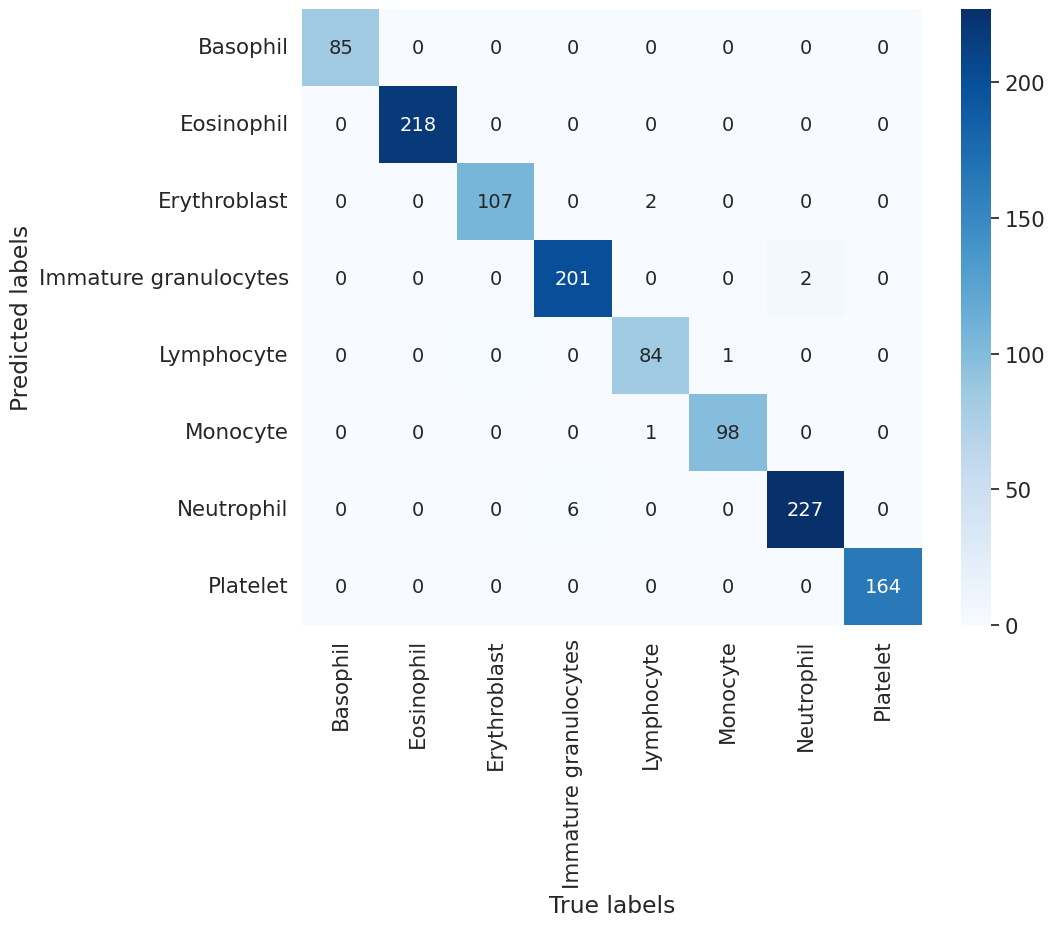

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

class_names = ["Basophil",

              "Eosinophil",

              "Erythroblast",

              "Immature granulocytes",

              "Lymphocyte",

              "Monocyte",

              "Neutrophil",

              "Platelet"

              ]



predictions = model.predict(X_val, verbose=0)



# Display the shape of the predictions

print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels

pred_classes = np.argmax(predictions, axis=-1)




# Extract ground truth classes

true_classes = np.argmax(y_val, axis=-1)


print(true_classes[:10])




# Calculate and display test set accuracy

accuracy = accuracy_score(true_classes, pred_classes)

print(f'Accuracy score over the test set: {round(accuracy, 8)}')



# Calculate and display test set precision

precision = precision_score(true_classes, pred_classes, average='weighted')

print(f'Precision score over the test set: {round(precision,8)}')



# Calculate and display test set recall

recall = recall_score(true_classes, pred_classes, average='weighted')

print(f'Recall score over the test set: {round(recall, 8)}')



# Calculate and display test set F1 score

f1 = f1_score(true_classes, pred_classes, average='weighted')

print(f'F1 score over the test set: {round(f1, 8)}')



# Compute the confusion matrix

cm = confusion_matrix(true_classes, pred_classes)



# Combine numbers and percentages into a single string for annotation

annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)



# Plot the confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_names), yticklabels=list(class_names), cmap='Blues')

plt.xlabel('True labels')

plt.ylabel('Predicted labels')

plt.show()


In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)